In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream

In [2]:
# Windows
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

In [ ]:
## Mac
#path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [3]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [4]:

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_cont2"] = estreams_attributes["perm_high_cont"]
estreams_attributes["perm_medium_cont2"] = estreams_attributes["perm_medium_cont"] + estreams_attributes["perm_low_cont"]
estreams_attributes["perm_low_cont2"] = estreams_attributes["perm_verylow_cont"]


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [176]:
# First we define the outlet of the Moselle to be used
outlets = ["FR001604"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["FR001604"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]
estreams_attributes_clipped_filters

100%|██████████| 1/1 [00:00<00:00, 500.39it/s]


,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
ES000333,9019,BOSSOST,ES,ES_CEDEX,NaN,0.691225,42.782327,0.691225,42.782327,700,...,27.632,0.014,1.160,6.0,0.0,97.0,3.0,0.000,5.999,94.000
ES000453,9143,ARTIES,ES,ES_CEDEX,NaN,0.879104,42.701971,0.879104,42.701971,1180,...,33.243,0.000,0.000,4.0,0.0,91.0,9.0,0.000,2.020,97.980
FR004086,O005002001,La Garonne Ã Chaum et Ã Fronsac,FR,FR_EAUFRANCE,La Garonne à Chaum et à Fronsac,0.647726,42.938900,0.647726,42.938900,465,...,21.069,0.014,1.160,8.0,12.0,84.0,4.0,0.107,4.369,95.523
FR004089,O014402001,La Neste ÃƒÂ Arreau [Aure],FR,FR_EAUFRANCE,La Neste à Arreau [Aure],0.356667,42.904167,0.357420,42.905599,NaN,...,25.661,0.000,0.000,3.0,28.0,61.0,11.0,0.000,2.623,97.377
FR004091,O023402001,Le Ger Ã Aspet [2],FR,FR_EAUFRANCE,Le Ger à Aspet [2],0.795350,43.021419,0.795350,43.021419,416,...,5.654,0.000,0.000,0.0,4.0,87.0,9.0,0.000,49.849,50.151
FR004114,O074404001,L'Arize au Mas-d'Azil,FR,FR_EAUFRANCE,L'Arize au Mas-d'Azil,1.361074,43.082951,1.361074,43.082951,280,...,1.393,1.178,0.915,1.0,24.0,75.0,1.0,0.000,56.047,43.953
FR004119,O095000101,Le Louge au Fousseret,FR,FR_EAUFRANCE,Le Louge au Fousseret,1.059950,43.267264,1.059950,43.267264,246,...,0.421,10.777,16.014,3.0,29.0,71.0,0.0,5.462,94.538,0.000
FR004120,O098401001,Le Louge Ã Muret,FR,FR_EAUFRANCE,Le Louge à Muret,1.317010,43.459968,1.317010,43.459968,163,...,0.396,61.881,80.417,5.0,55.0,45.0,0.0,31.056,68.944,0.000
FR004128,O125251001,L'AriÃ¨ge Ã Foix,FR,FR_EAUFRANCE,L'Ariège à Foix,1.608853,42.966262,1.608853,42.966262,375,...,18.597,0.000,0.000,5.0,7.0,87.0,6.0,0.000,56.023,43.977


In [177]:
estreams_attributes_clipped_filters.corr(method="pearson")["baseflow_index"][-10:]

C:\Users\nascimth\AppData\Local\Temp\ipykernel_35104\7039467.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  estreams_attributes_clipped_filters.corr(method="pearson")["baseflow_index"][-10:]


sno_cov_mean           0.716430
irri_1990              0.178496
irri_2005              0.164229
stations_num_p_mean    0.405819
perm_high_glob2        0.019563
perm_medium_glob2     -0.165557
perm_low_glob2         0.676581
perm_high_cont2       -0.107042
perm_medium_cont2     -0.788993
perm_low_cont2         0.752368
Name: baseflow_index, dtype: float64

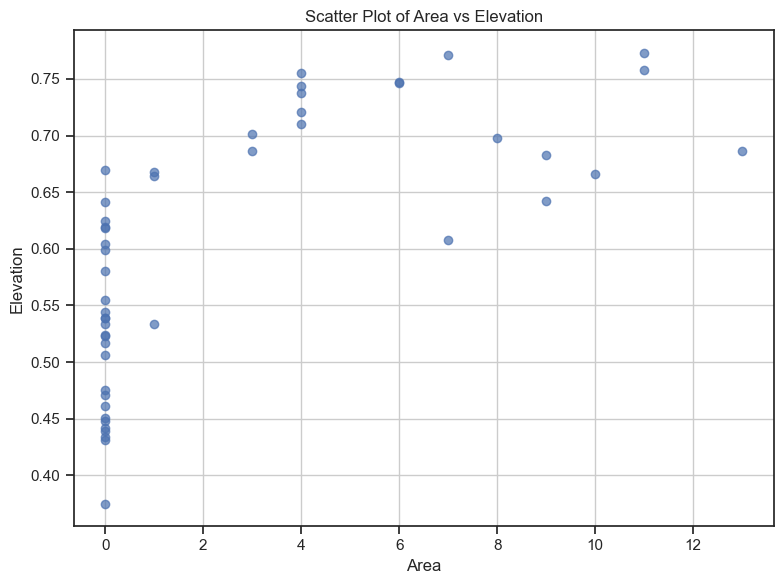

In [178]:
import matplotlib.pyplot as plt

# Example: Plot 'area' vs 'elevation'
plt.figure(figsize=(8, 6))
plt.scatter(estreams_attributes_clipped_filters["perm_low_glob2"], estreams_attributes_clipped_filters["baseflow_index"], alpha=0.7)
plt.xlabel("Area")
plt.ylabel("Elevation")
plt.title("Scatter Plot of Area vs Elevation")
plt.grid(True)
plt.tight_layout()
plt.show()


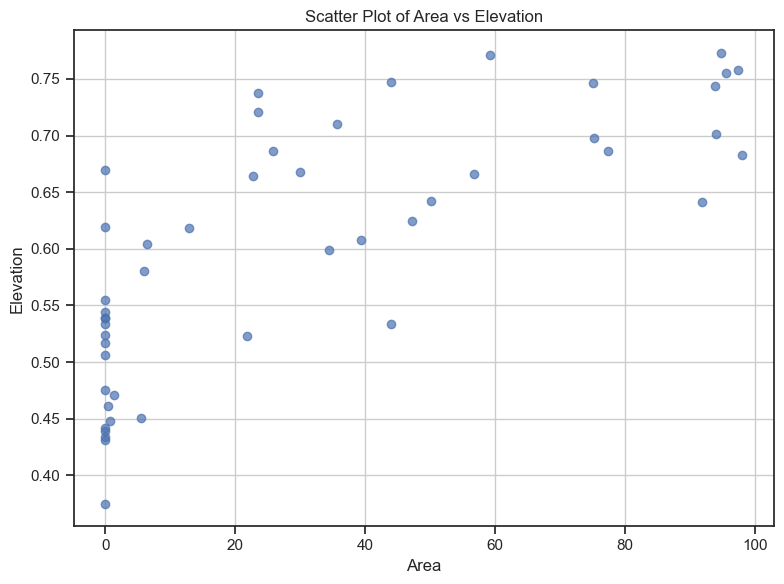

In [179]:
import matplotlib.pyplot as plt

# Example: Plot 'area' vs 'elevation'
plt.figure(figsize=(8, 6))
plt.scatter(estreams_attributes_clipped_filters["perm_low_cont2"], estreams_attributes_clipped_filters["baseflow_index"], alpha=0.7)
plt.xlabel("Area")
plt.ylabel("Elevation")
plt.title("Scatter Plot of Area vs Elevation")
plt.grid(True)
plt.tight_layout()
plt.show()


In [180]:
len(estreams_attributes_clipped_filters)

48

In [181]:
estreams_attributes_clipped_filters

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
ES000333,9019,BOSSOST,ES,ES_CEDEX,NaN,0.691225,42.782327,0.691225,42.782327,700,...,27.632,0.014,1.160,6.0,0.0,97.0,3.0,0.000,5.999,94.000
ES000453,9143,ARTIES,ES,ES_CEDEX,NaN,0.879104,42.701971,0.879104,42.701971,1180,...,33.243,0.000,0.000,4.0,0.0,91.0,9.0,0.000,2.020,97.980
FR004086,O005002001,La Garonne Ã Chaum et Ã Fronsac,FR,FR_EAUFRANCE,La Garonne à Chaum et à Fronsac,0.647726,42.938900,0.647726,42.938900,465,...,21.069,0.014,1.160,8.0,12.0,84.0,4.0,0.107,4.369,95.523
FR004089,O014402001,La Neste ÃƒÂ Arreau [Aure],FR,FR_EAUFRANCE,La Neste à Arreau [Aure],0.356667,42.904167,0.357420,42.905599,NaN,...,25.661,0.000,0.000,3.0,28.0,61.0,11.0,0.000,2.623,97.377
FR004091,O023402001,Le Ger Ã Aspet [2],FR,FR_EAUFRANCE,Le Ger à Aspet [2],0.795350,43.021419,0.795350,43.021419,416,...,5.654,0.000,0.000,0.0,4.0,87.0,9.0,0.000,49.849,50.151
FR004114,O074404001,L'Arize au Mas-d'Azil,FR,FR_EAUFRANCE,L'Arize au Mas-d'Azil,1.361074,43.082951,1.361074,43.082951,280,...,1.393,1.178,0.915,1.0,24.0,75.0,1.0,0.000,56.047,43.953
FR004119,O095000101,Le Louge au Fousseret,FR,FR_EAUFRANCE,Le Louge au Fousseret,1.059950,43.267264,1.059950,43.267264,246,...,0.421,10.777,16.014,3.0,29.0,71.0,0.0,5.462,94.538,0.000
FR004120,O098401001,Le Louge Ã Muret,FR,FR_EAUFRANCE,Le Louge à Muret,1.317010,43.459968,1.317010,43.459968,163,...,0.396,61.881,80.417,5.0,55.0,45.0,0.0,31.056,68.944,0.000
FR004128,O125251001,L'AriÃ¨ge Ã Foix,FR,FR_EAUFRANCE,L'Ariège à Foix,1.608853,42.966262,1.608853,42.966262,375,...,18.597,0.000,0.000,5.0,7.0,87.0,6.0,0.000,56.023,43.977


In [182]:
basins_problems2 = pd.read_csv(r"..\data\basins_problems_filter_2.csv")
basins_problems2

,basin
0,AT000080
1,AT000120
2,AT000159
3,AT000372
4,AT000373
...,...
369,SE000083
370,SE000103
371,SE000118
372,SI000029


In [183]:
Outliers = ["DEBB0050", 
"DK000087",
"ES000172",
"ES000478",
"ES001114",
"FI000202",
"FI000506",
"FR001271",
"FR001475",
"ITIS0107",
"NL000012",
"PT000211",
"PT000218",
"PT000263",
"DEHE0953",
"DEHE0970",
"DEHE0989",
"DEHE1008",
"DEHE1013",
"DEHE1014",
"DK000094"]

In [184]:
estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters[~estreams_attributes_clipped_filters.index.isin(basins_problems2.basin)]
estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters2.drop(["ES000333", "FR004131"])

len(estreams_attributes_clipped_filters2)

44

In [28]:
# Create a folder to save the plots
output_dir = r"..\results\plots\garonne"
os.makedirs(output_dir, exist_ok=True)

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters.index):
    csv_file = fr"C:\Users\nascimth\Documents\data\EStreams\data\estreams_timeseries_{basin_id}.csv"
    
    df = pd.read_csv(csv_file)
    
    column_name = basin_id
    
    # Ensure the first column is treated as the Date index
    df.set_index(df.columns[0], inplace=True)
    df = df.loc["1988-10-01":"2015-09-30"]

    # Plotting
    plt.figure(figsize=(10, 4))
    df['q_mean'].plot(linewidth=0.5)
    plt.title(f"Basin: {basin_id}")
    plt.xlabel("Date")
    plt.ylabel("q_mean")
    #plt.xlim("1988","2015")

    #plt.tight_layout()

    # Save the plot
    output_path = os.path.join(output_dir, f"{basin_id}.png")
    plt.savefig(output_path)
    plt.close()  # Close the plot to avoid overlap in next iteration

100%|██████████| 48/48 [00:16<00:00,  2.99it/s]


<Axes: >

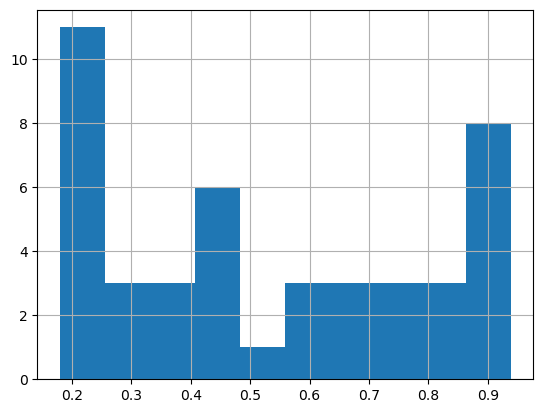

In [30]:
estreams_attributes_clipped_filters2.q_runoff_ratio.hist()

In [31]:
estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.q_runoff_ratio<0.3]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
FR004119,O095000101,Le Louge au Fousseret,FR,FR_EAUFRANCE,Le Louge au Fousseret,1.059950,43.267264,1.059950,43.267264,246,...,0.421,10.777,16.014,3.0,29.0,71.0,0.0,5.462,94.538,0.000
FR004140,O163401001,La VixiÃ¨ge Ã Belpech,FR,FR_EAUFRANCE,La Vixiège à Belpech,1.749951,43.201718,1.749951,43.201718,243,...,0.466,36.387,34.400,4.0,11.0,89.0,0.0,7.812,92.188,0.000
FR004148,O182401001,La LÃ¨ze au Fossat,FR,FR_EAUFRANCE,La Lèze au Fossat,1.408875,43.174989,1.408875,43.174989,244,...,0.480,4.028,2.529,2.0,2.0,98.0,0.0,0.438,98.245,1.317
FR004149,O184402001,La LÃ¨ze Ã LÃ©zat-sur-LÃ¨ze,FR,FR_EAUFRANCE,La Lèze à Lézat-sur-Lèze,1.352878,43.280809,1.352878,43.280809,199,...,0.439,20.228,16.084,2.0,6.0,94.0,0.0,6.526,92.809,0.664
FR004152,O187401001,La LÃ¨ze Ã Labarthe-sur-LÃ¨ze,FR,FR_EAUFRANCE,La Lèze à Labarthe-sur-Lèze,1.406594,43.451190,1.406594,43.451190,159,...,0.407,29.664,24.070,3.0,14.0,86.0,0.0,18.370,81.174,0.456
FR004153,O193431001,Le Touch Ã BÃ©rat,FR,FR_EAUFRANCE,Le Touch à Bérat,1.173668,43.384109,1.173668,43.384109,208,...,0.340,30.921,38.936,1.0,30.0,70.0,0.0,2.711,97.289,0.000
FR004154,O203401001,L'Aussonnelle Ã Seilh,FR,FR_EAUFRANCE,L'Aussonnelle à Seilh,1.355595,43.691837,1.355595,43.691837,115,...,0.284,24.538,32.923,3.0,96.0,4.0,0.0,38.065,61.935,0.000
FR004156,O217251001,L'Hers ÃƒÂ BaziÃƒÂ¨ge,FR,FR_EAUFRANCE,L'Hers à Baziège,1.610944,43.451194,1.610944,43.451194,153,...,0.366,46.231,51.141,3.0,12.0,88.0,0.0,12.515,87.485,0.000
FR004160,O234401001,Le Girou Ã CÃ©pet,FR,FR_EAUFRANCE,Le Girou à Cépet,1.433759,43.752697,1.433759,43.752697,126,...,0.313,75.349,118.812,2.0,11.0,89.0,0.0,10.841,89.159,0.000


In [32]:
estreams_attributes_clipped_filters2

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
FR004086,O005002001,La Garonne Ã Chaum et Ã Fronsac,FR,FR_EAUFRANCE,La Garonne à Chaum et à Fronsac,0.647726,42.938900,0.647726,42.938900,465,...,21.069,0.014,1.160,8.0,12.0,84.0,4.0,0.107,4.369,95.523
FR004089,O014402001,La Neste ÃƒÂ Arreau [Aure],FR,FR_EAUFRANCE,La Neste à Arreau [Aure],0.356667,42.904167,0.357420,42.905599,NaN,...,25.661,0.000,0.000,3.0,28.0,61.0,11.0,0.000,2.623,97.377
FR004091,O023402001,Le Ger Ã Aspet [2],FR,FR_EAUFRANCE,Le Ger à Aspet [2],0.795350,43.021419,0.795350,43.021419,416,...,5.654,0.000,0.000,0.0,4.0,87.0,9.0,0.000,49.849,50.151
FR004114,O074404001,L'Arize au Mas-d'Azil,FR,FR_EAUFRANCE,L'Arize au Mas-d'Azil,1.361074,43.082951,1.361074,43.082951,280,...,1.393,1.178,0.915,1.0,24.0,75.0,1.0,0.000,56.047,43.953
FR004119,O095000101,Le Louge au Fousseret,FR,FR_EAUFRANCE,Le Louge au Fousseret,1.059950,43.267264,1.059950,43.267264,246,...,0.421,10.777,16.014,3.0,29.0,71.0,0.0,5.462,94.538,0.000
FR004120,O098401001,Le Louge Ã Muret,FR,FR_EAUFRANCE,Le Louge à Muret,1.317010,43.459968,1.317010,43.459968,163,...,0.396,61.881,80.417,5.0,55.0,45.0,0.0,31.056,68.944,0.000
FR004128,O125251001,L'AriÃ¨ge Ã Foix,FR,FR_EAUFRANCE,L'Ariège à Foix,1.608853,42.966262,1.608853,42.966262,375,...,18.597,0.000,0.000,5.0,7.0,87.0,6.0,0.000,56.023,43.977
FR004130,O137251002,L'AriÃ¨ge Ã Saverdun,FR,FR_EAUFRANCE,L'Ariège à Saverdun,1.577842,43.231948,1.577842,43.231948,220,...,14.234,38.132,32.364,7.0,12.0,81.0,7.0,5.857,54.801,39.342
FR004132,O144291002,Le Grand Hers Ã Laroque-d'Olmes et au Peyrat,FR,FR_EAUFRANCE,Le Grand Hers à Laroque-d'Olmes et au Peyrat,1.935437,42.954244,1.935437,42.954244,413,...,7.511,0.000,0.020,2.0,11.0,88.0,1.0,0.000,77.255,22.745


In [185]:
import pandas as pd
import os
import tqdm

data_folder = r"C:\Users\nascimth\Documents\data\EStreams\data"
gantt_segments = []

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters2.index):
    file_path = os.path.join(data_folder, f"estreams_timeseries_{basin_id}.csv")

    # Load CSV with datetime index
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    data = data.loc["1988-10-01":"2015-09-30"]

    # Get availability mask
    valid = data["q_mean"].notna()

    # Identify change points in availability (True to False or vice-versa)
    change_points = valid.ne(valid.shift()).cumsum()

    # Group by continuous segments
    for grp, seg in data[valid].groupby(change_points):
        start = seg.index.min()
        end = seg.index.max()
        gantt_segments.append((basin_id, start, end))


100%|██████████| 44/44 [00:02<00:00, 21.87it/s]


In [186]:
gantt_df = pd.DataFrame(gantt_segments, columns=["basin", "start", "end"])
gantt_df = gantt_df.sort_values(["basin", "start"]).reset_index(drop=True)

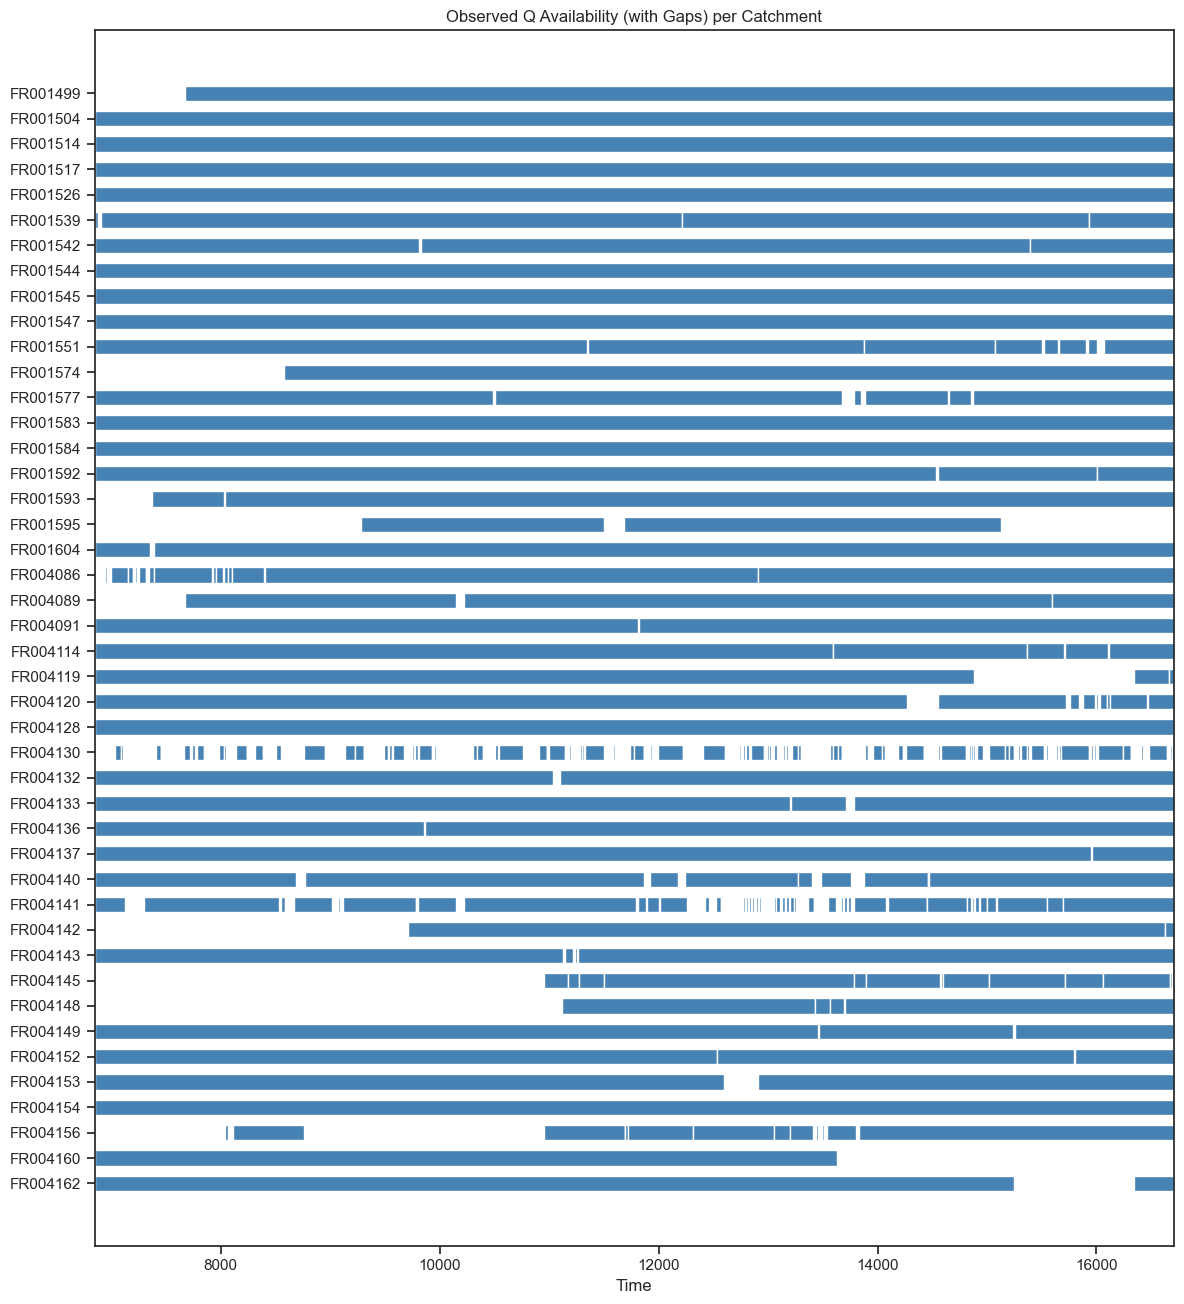

In [187]:
import matplotlib.pyplot as plt

# Assign a numeric index for plotting on y-axis
basin_to_y = {basin: i for i, basin in enumerate(gantt_df["basin"].unique())}
gantt_df["y"] = gantt_df["basin"].map(basin_to_y)

fig, ax = plt.subplots(figsize=(12, len(basin_to_y) * 0.3))

for _, row in gantt_df.iterrows():
    width = (row["end"] - row["start"]).days
    ax.barh(y=row["y"], left=row["start"], width=width, height=0.6, color="steelblue")

ax.set_yticks(list(basin_to_y.values()))
ax.set_yticklabels(list(basin_to_y.keys()))
ax.invert_yaxis()
ax.set_xlabel("Time")
ax.set_title("Observed Q Availability (with Gaps) per Catchment")
plt.tight_layout()
plt.show()


In [188]:
estreams_attributes_clipped_filters2[estreams_attributes_clipped_filters2.q_runoff_ratio<0.3].q_runoff_ratio

basin_id
FR004119    0.274
FR004140    0.271
FR004148    0.219
FR004149    0.228
FR004152    0.217
FR004153    0.209
FR004154    0.210
FR004156    0.252
FR004160    0.211
FR004162    0.225
FR001526    0.293
FR001592    0.180
FR001593    0.205
FR001595    0.181
Name: q_runoff_ratio, dtype: float64

In [189]:
estreams_attributes_clipped_filters_to_be_sorted = estreams_attributes_clipped_filters2.copy()

# At this part we sort the values in order according to the area, and select the second as done in the Moselle paper originally. 
# Sort the DataFrame by 'area_estreams'
estreams_attributes_clipped_sorted = estreams_attributes_clipped_filters_to_be_sorted.sort_values(by='area_estreams')

estreams_attributes_clipped_sorted.loc[:, ["area_estreams"]]

,area_estreams
basin_id,
FR001504,66.460
FR004136,68.443
FR004133,70.736
FR001547,90.577
FR001544,91.751
FR004091,93.134
FR004137,93.890
FR001592,108.995
FR001526,120.325


In [ ]:
import geopandas as gpd
moselle=gpd.read_file(r"..\data\shps\moselle_delienation.shp")
garonne=gpd.read_file(r"..\data\shps\garonne.shp")

rivers_moselle=gpd.read_file(r"..\data\shps\rivers_moselle.shp")

### Current approach

In [190]:
import numpy as np
import pandas as pd

# Parameters
n_groups = 4

# Base dataframe
df_sorted = estreams_attributes_clipped_sorted.copy().reset_index(drop=True)
df_sorted["basin_id"] = estreams_attributes_clipped_sorted.index

total_gauges = len(df_sorted)

# Step 1: Sort by area for stratification
df_sorted = df_sorted.sort_values(by="area_estreams").reset_index(drop=True)

# Step 2: Determine gauges per group
gauges_per_group = total_gauges // n_groups
extra_gauges = total_gauges % n_groups  # Remainder

# Step 3: Create strata for balanced sampling
strata = np.array_split(df_sorted, total_gauges)

# Step 4: Round-robin assignment with randomness
np.random.seed(42)
grouped_gauges = {f'Group_{i+1}': [] for i in range(n_groups)}
group_cycle = list(grouped_gauges.keys()) * ((len(strata) // n_groups) + 2)
group_idx = 0

for stratum in strata:
    selected = stratum.sample(n=1, random_state=np.random.randint(10000)).iloc[0]
    group = group_cycle[group_idx]
    grouped_gauges[group].append(selected)
    group_idx += 1

# Step 5: Convert to DataFrames
groups_df = {k: pd.DataFrame(v).reset_index(drop=True) for k, v in grouped_gauges.items()}
all_combined = pd.concat(groups_df.values())

# Final checks
print(f"\n✅ Total gauges assigned: {len(all_combined)} (should be {len(df_sorted)})")
print(f"✅ Unique basin_ids: {all_combined['basin_id'].nunique()} (should be {len(df_sorted)})")
print(f"✅ Any duplicates? {all_combined['basin_id'].duplicated().any()}")

# Summary per group
for k, g in groups_df.items():
    print(f"{k}: {len(g)} gauges | Mean area: {g['area_estreams'].mean():.1f}")



✅ Total gauges assigned: 44 (should be 44)
✅ Unique basin_ids: 44 (should be 44)
✅ Any duplicates? False
Group_1: 11 gauges | Mean area: 732.0
Group_2: 11 gauges | Mean area: 761.1
Group_3: 11 gauges | Mean area: 1415.1
Group_4: 11 gauges | Mean area: 1854.9


In [191]:
groups_df["Group_1"]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2,basin_id
0,O012622101,O0126210,FR,FR_EAUFRANCE,La Neste de Rioumajou à Tramezaïgues [Maison B...,0.299401,42.792046,0.299401,42.792046,1026,...,0.000,0.000,2.0,12.0,88.0,0.0,0.000,8.187,91.812,FR001504
1,O055401001,O0554010,FR,FR_EAUFRANCE,L'Arbas à Castelbiague [Pont de Prades],0.928657,43.046218,0.928657,43.046218,332,...,0.000,0.195,0.0,12.0,88.0,0.0,0.000,99.999,0.001,FR001544
2,O029531001,O0295310,FR,FR_EAUFRANCE,La Noue à Laffite-Toupière [Moulin Laffite],0.914831,43.170610,0.914831,43.170610,291,...,0.246,2.672,2.0,19.0,81.0,0.0,0.947,99.053,0.000,FR001526
3,O203401001,L'Aussonnelle Ã Seilh,FR,FR_EAUFRANCE,L'Aussonnelle à Seilh,1.355595,43.691837,1.355595,43.691837,115,...,24.538,32.923,3.0,96.0,4.0,0.0,38.065,61.935,0.000,FR004154
4,O184402001,La LÃ¨ze Ã LÃ©zat-sur-LÃ¨ze,FR,FR_EAUFRANCE,La Lèze à Lézat-sur-Lèze,1.352878,43.280809,1.352878,43.280809,199,...,20.228,16.084,2.0,6.0,94.0,0.0,6.526,92.809,0.664,FR004149
5,O048401001,O0484010,FR,FR_EAUFRANCE,Le Lez à Engomer [Balaguères],1.055137,42.949466,1.055137,42.949466,455,...,0.000,0.000,1.0,18.0,74.0,8.0,0.000,24.782,75.218,FR001539
6,O098401001,Le Louge Ã Muret,FR,FR_EAUFRANCE,Le Louge à Muret,1.317010,43.459968,1.317010,43.459968,163,...,61.881,80.417,5.0,55.0,45.0,0.0,31.056,68.944,0.000,FR004120
7,O017402701,O0174010,FR,FR_EAUFRANCE,La Neste à Sarrancolin [Beyrède],0.380714,42.956531,0.380714,42.956531,630,...,0.000,0.000,3.0,36.0,53.0,11.0,0.000,5.252,94.748,FR001514
8,O255000201,La Save Ã Larra,FR,FR_EAUFRANCE,La Save à Larra,1.244217,43.728025,1.244217,43.728025,111,...,88.317,120.641,7.0,30.0,70.0,0.0,17.266,82.734,0.000,FR004162
9,O166291001,Le Grand Hers Ã Calmont,FR,FR_EAUFRANCE,Le Grand Hers à Calmont,1.595355,43.292483,1.595355,43.292483,201,...,140.568,129.335,8.0,23.0,77.0,0.0,19.471,74.510,6.020,FR004142


In [192]:
groups_df["Group_3"][["basin_id", "area_estreams", 'perm_high_cont2',
       'perm_medium_cont2', 'perm_low_cont2']].sort_values("area_estreams")

,basin_id,area_estreams,perm_high_cont2,perm_medium_cont2,perm_low_cont2
0,FR004133,70.736,0.000,100.000,0.000
1,FR004137,93.890,0.000,65.638,34.361
2,FR001577,135.007,0.000,94.518,5.483
3,FR004140,196.522,7.812,92.188,0.000
4,FR001595,312.650,0.000,100.000,0.000
5,FR004089,400.328,0.000,2.623,97.377
6,FR004160,525.849,10.841,89.159,0.000
7,FR001593,793.654,18.997,81.003,0.000
8,FR004141,1286.092,13.876,79.686,6.438
9,FR004130,1806.992,5.857,54.801,39.342


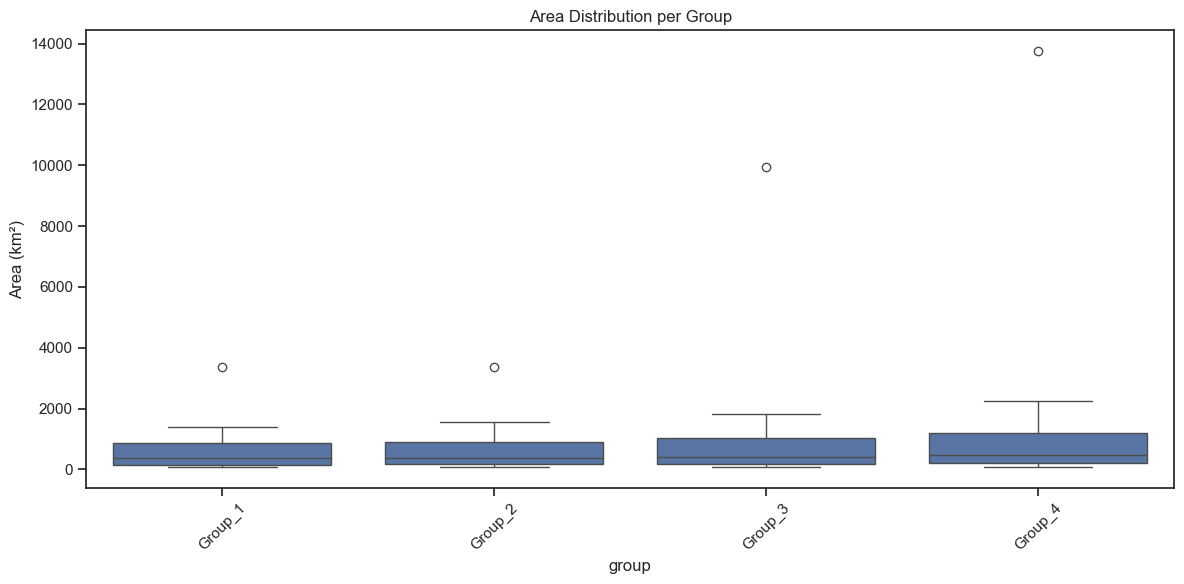

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

combined_df = pd.concat([
    g.assign(group=group_name) for group_name, g in groups_df.items()
])

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='group', y='area_estreams')
plt.title("Area Distribution per Group")
plt.ylabel("Area (km²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [194]:
combined_df[combined_df.group == GROUP]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2,basin_id,group
0,O149431003,Le Touyre Ã Lavelanet et Ã Saint-Quentin-la-...,FR,FR_EAUFRANCE,Le Touyre à Lavelanet et à Saint-Quentin-la-Tour,1.850824,42.940862,1.850824,42.940862,442,...,0.000,1.0,23.0,77.0,0.0,0.000,52.863,47.137,FR004136,Group_2
1,O023402001,Le Ger Ã Aspet [2],FR,FR_EAUFRANCE,Le Ger à Aspet [2],0.795350,43.021419,0.795350,43.021419,416,...,0.000,0.0,4.0,87.0,9.0,0.000,49.849,50.151,FR004091,Group_2
2,O182401001,La LÃ¨ze au Fossat,FR,FR_EAUFRANCE,La Lèze au Fossat,1.408875,43.174989,1.408875,43.174989,244,...,2.529,2.0,2.0,98.0,0.0,0.438,98.245,1.317,FR004148,Group_2
3,O144291002,Le Grand Hers Ã Laroque-d'Olmes et au Peyrat,FR,FR_EAUFRANCE,Le Grand Hers à Laroque-d'Olmes et au Peyrat,1.935437,42.954244,1.935437,42.954244,413,...,0.020,2.0,11.0,88.0,1.0,0.000,77.255,22.745,FR004132,Group_2
4,O095000101,Le Louge au Fousseret,FR,FR_EAUFRANCE,Le Louge au Fousseret,1.059950,43.267264,1.059950,43.267264,246,...,16.014,3.0,29.0,71.0,0.0,5.462,94.538,0.000,FR004119,Group_2
5,O187401001,La LÃ¨ze Ã Labarthe-sur-LÃ¨ze,FR,FR_EAUFRANCE,La Lèze à Labarthe-sur-Lèze,1.406594,43.451190,1.406594,43.451190,159,...,24.070,3.0,14.0,86.0,0.0,18.370,81.174,0.456,FR004152,Group_2
6,O198431001,O1984310,FR,FR_EAUFRANCE,Le Touch à Toulouse [Saint-Martin-du-Touch],1.376184,43.598683,1.376184,43.598683,143,...,87.251,3.0,71.0,29.0,0.0,42.497,57.503,0.000,FR001583,Group_2
7,O001004003,O0010040,FR,FR_EAUFRANCE,La Garonne à Arlos et à Saint-Béat,0.692109,42.915356,0.692109,42.915356,500,...,1.160,6.0,2.0,94.0,4.0,0.000,6.221,93.779,FR001499,Group_2
8,O050252002,O0502520,FR,FR_EAUFRANCE,Le Salat à Saint-Lizier [Saint Girons],1.140881,42.991501,1.140881,42.991501,382,...,0.000,2.0,18.0,69.0,13.0,0.000,22.730,77.271,FR001542,Group_2
9,O059251001,O0592510,FR,FR_EAUFRANCE,Le Salat à Roquefort-sur-Garonne,0.973925,43.154443,0.973925,43.154443,270,...,1.703,3.0,19.0,71.0,10.0,0.200,43.064,56.734,FR001545,Group_2


<Axes: >

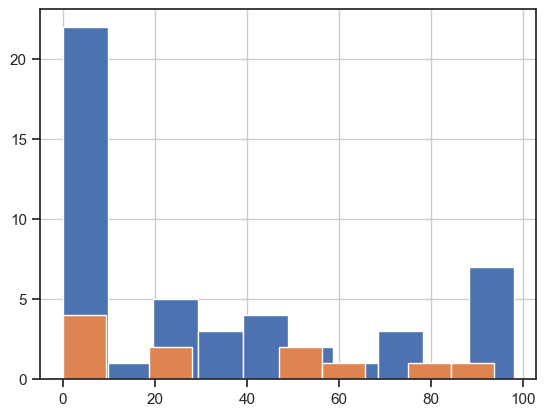

In [197]:
GROUP = "Group_2"
list_cal = combined_df[combined_df.group == GROUP].basin_id.tolist()
estreams_attributes_clipped_filters.perm_low_cont2.hist()
estreams_attributes_clipped_filters.loc[list_cal].sort_values("area_estreams").perm_low_cont2.hist()

<Axes: >

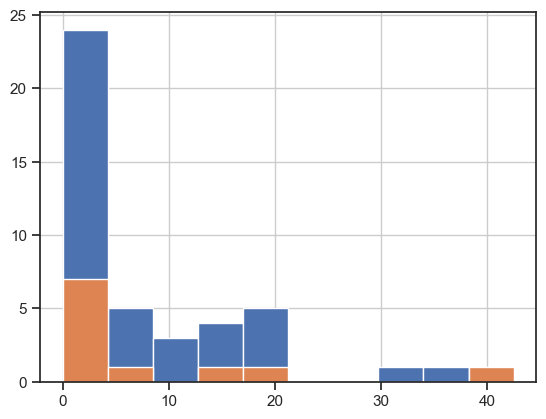

In [198]:
GROUP = "Group_2"
list_cal = combined_df[combined_df.group == GROUP].basin_id.tolist()
estreams_attributes_clipped_filters2.perm_high_cont2.hist()
estreams_attributes_clipped_filters2.loc[list_cal].sort_values("area_estreams").perm_high_cont2.hist()

In [199]:
df = combined_df[combined_df.group != GROUP]
df

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2,basin_id,group
0,O012622101,O0126210,FR,FR_EAUFRANCE,La Neste de Rioumajou à Tramezaïgues [Maison B...,0.299401,42.792046,0.299401,42.792046,1026,...,0.000,2.0,12.0,88.0,0.0,0.000,8.187,91.812,FR001504,Group_1
1,O055401001,O0554010,FR,FR_EAUFRANCE,L'Arbas à Castelbiague [Pont de Prades],0.928657,43.046218,0.928657,43.046218,332,...,0.195,0.0,12.0,88.0,0.0,0.000,99.999,0.001,FR001544,Group_1
2,O029531001,O0295310,FR,FR_EAUFRANCE,La Noue à Laffite-Toupière [Moulin Laffite],0.914831,43.170610,0.914831,43.170610,291,...,2.672,2.0,19.0,81.0,0.0,0.947,99.053,0.000,FR001526,Group_1
3,O203401001,L'Aussonnelle Ã Seilh,FR,FR_EAUFRANCE,L'Aussonnelle à Seilh,1.355595,43.691837,1.355595,43.691837,115,...,32.923,3.0,96.0,4.0,0.0,38.065,61.935,0.000,FR004154,Group_1
4,O184402001,La LÃ¨ze Ã LÃ©zat-sur-LÃ¨ze,FR,FR_EAUFRANCE,La Lèze à Lézat-sur-Lèze,1.352878,43.280809,1.352878,43.280809,199,...,16.084,2.0,6.0,94.0,0.0,6.526,92.809,0.664,FR004149,Group_1
5,O048401001,O0484010,FR,FR_EAUFRANCE,Le Lez à Engomer [Balaguères],1.055137,42.949466,1.055137,42.949466,455,...,0.000,1.0,18.0,74.0,8.0,0.000,24.782,75.218,FR001539,Group_1
6,O098401001,Le Louge Ã Muret,FR,FR_EAUFRANCE,Le Louge à Muret,1.317010,43.459968,1.317010,43.459968,163,...,80.417,5.0,55.0,45.0,0.0,31.056,68.944,0.000,FR004120,Group_1
7,O017402701,O0174010,FR,FR_EAUFRANCE,La Neste à Sarrancolin [Beyrède],0.380714,42.956531,0.380714,42.956531,630,...,0.000,3.0,36.0,53.0,11.0,0.000,5.252,94.748,FR001514,Group_1
8,O255000201,La Save Ã Larra,FR,FR_EAUFRANCE,La Save à Larra,1.244217,43.728025,1.244217,43.728025,111,...,120.641,7.0,30.0,70.0,0.0,17.266,82.734,0.000,FR004162,Group_1
9,O166291001,Le Grand Hers Ã Calmont,FR,FR_EAUFRANCE,Le Grand Hers à Calmont,1.595355,43.292483,1.595355,43.292483,201,...,129.335,8.0,23.0,77.0,0.0,19.471,74.510,6.020,FR004142,Group_1


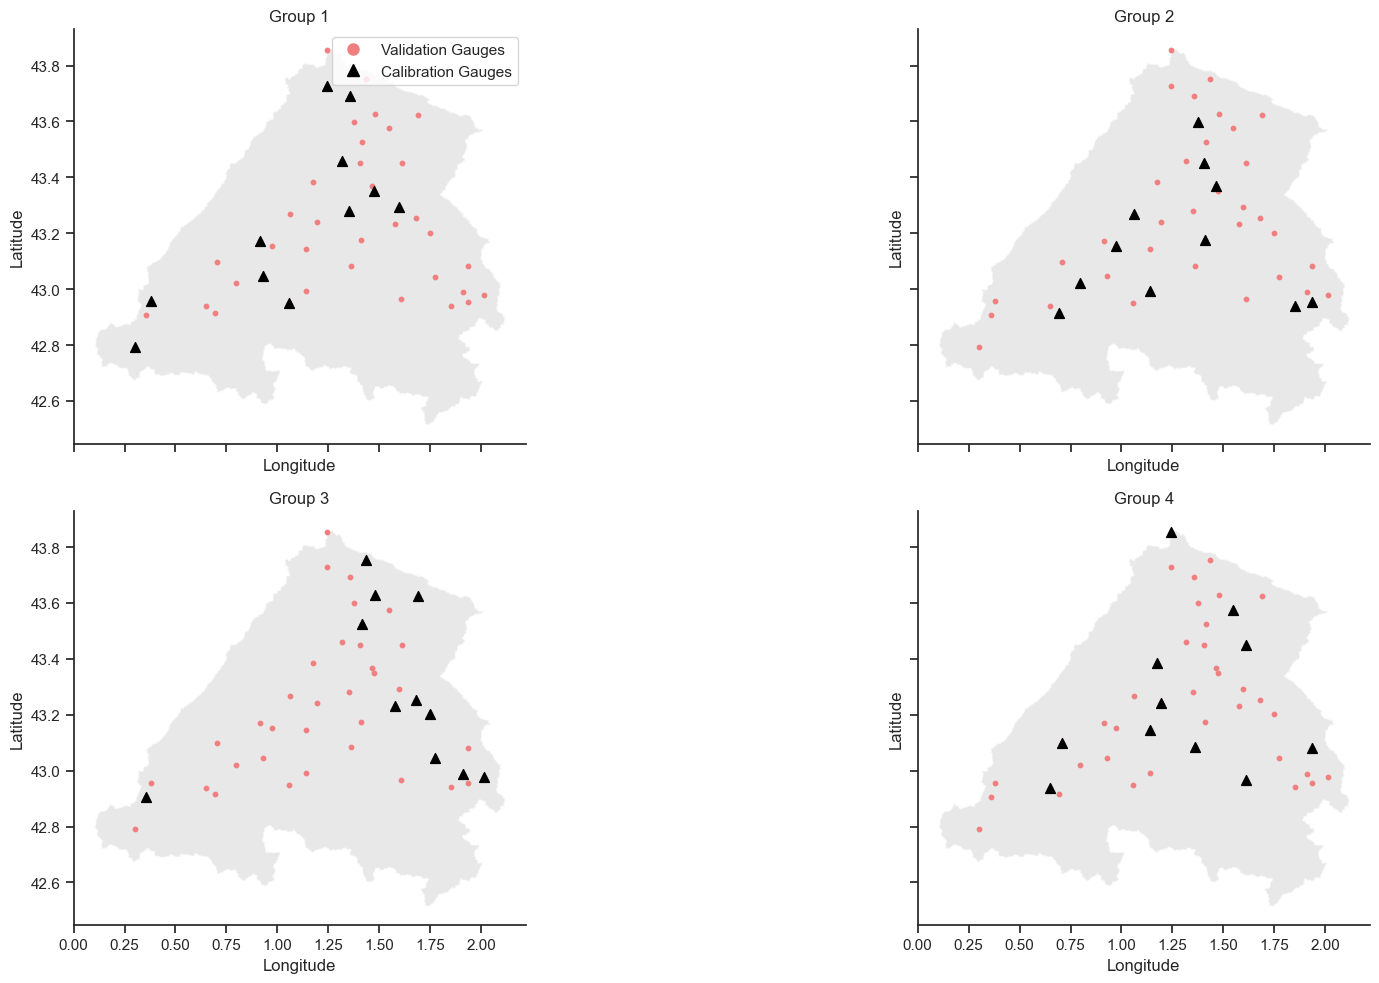

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines

sns.set_theme(style="ticks")

# Prepare data
df = estreams_attributes_clipped_filters2.copy()
group_coords = [group[["basin_id"]] for group in groups_df.values()]
group_coords = [network_estreams.loc[g["basin_id"].tolist()] for g in group_coords]

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Base map
    garonne.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
    #rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

    # All gauges in red (background)
    ax.scatter(
        df["lon"], df["lat"],
        color='lightcoral', s=10, label='Validation Gauges', zorder=2
    )

    if i < len(group_coords):
        # Plot group gauges (triangle)
        ax.scatter(
            group_coords[i]["lon"],
            group_coords[i]["lat"],
            marker='^',
            color='black',
            s=50,
            zorder=3,
            label=f'Group {i+1}'
        )
        ax.set_title(f"Group {i+1}")
    else:
        ax.set_title("Empty")

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(False)
    sns.despine(ax=ax)

# Legend (shared handles)
validation_handle = mlines.Line2D([], [], color='lightcoral', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')
axes[0].legend(handles=[validation_handle, calibration_handle], loc='upper right')

plt.tight_layout()
plt.show()


In [201]:
combined_df

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2,basin_id,group
0,O012622101,O0126210,FR,FR_EAUFRANCE,La Neste de Rioumajou à Tramezaïgues [Maison B...,0.299401,42.792046,0.299401,42.792046,1026,...,0.000,2.0,12.0,88.0,0.0,0.000,8.187,91.812,FR001504,Group_1
1,O055401001,O0554010,FR,FR_EAUFRANCE,L'Arbas à Castelbiague [Pont de Prades],0.928657,43.046218,0.928657,43.046218,332,...,0.195,0.0,12.0,88.0,0.0,0.000,99.999,0.001,FR001544,Group_1
2,O029531001,O0295310,FR,FR_EAUFRANCE,La Noue à Laffite-Toupière [Moulin Laffite],0.914831,43.170610,0.914831,43.170610,291,...,2.672,2.0,19.0,81.0,0.0,0.947,99.053,0.000,FR001526,Group_1
3,O203401001,L'Aussonnelle Ã Seilh,FR,FR_EAUFRANCE,L'Aussonnelle à Seilh,1.355595,43.691837,1.355595,43.691837,115,...,32.923,3.0,96.0,4.0,0.0,38.065,61.935,0.000,FR004154,Group_1
4,O184402001,La LÃ¨ze Ã LÃ©zat-sur-LÃ¨ze,FR,FR_EAUFRANCE,La Lèze à Lézat-sur-Lèze,1.352878,43.280809,1.352878,43.280809,199,...,16.084,2.0,6.0,94.0,0.0,6.526,92.809,0.664,FR004149,Group_1
5,O048401001,O0484010,FR,FR_EAUFRANCE,Le Lez à Engomer [Balaguères],1.055137,42.949466,1.055137,42.949466,455,...,0.000,1.0,18.0,74.0,8.0,0.000,24.782,75.218,FR001539,Group_1
6,O098401001,Le Louge Ã Muret,FR,FR_EAUFRANCE,Le Louge à Muret,1.317010,43.459968,1.317010,43.459968,163,...,80.417,5.0,55.0,45.0,0.0,31.056,68.944,0.000,FR004120,Group_1
7,O017402701,O0174010,FR,FR_EAUFRANCE,La Neste à Sarrancolin [Beyrède],0.380714,42.956531,0.380714,42.956531,630,...,0.000,3.0,36.0,53.0,11.0,0.000,5.252,94.748,FR001514,Group_1
8,O255000201,La Save Ã Larra,FR,FR_EAUFRANCE,La Save à Larra,1.244217,43.728025,1.244217,43.728025,111,...,120.641,7.0,30.0,70.0,0.0,17.266,82.734,0.000,FR004162,Group_1
9,O166291001,Le Grand Hers Ã Calmont,FR,FR_EAUFRANCE,Le Grand Hers à Calmont,1.595355,43.292483,1.595355,43.292483,201,...,129.335,8.0,23.0,77.0,0.0,19.471,74.510,6.020,FR004142,Group_1


In [203]:
combined_df.to_csv("../data/network_estreams_garonne_44_gauges.csv")


# End